In [1]:
import numpy as np
import os
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from scipy.special import softmax

from sklearn.datasets import make_blobs
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE  # Import TSNE

import matplotlib.pyplot as plt

In [2]:
def compute_entropy_in_predictions( 
    embeddings: np.array,
    all_predictions: np.array
):

    unique_predictions = np.unique(all_predictions)

    all_prediction_centroids = []
    for prediction in unique_predictions:
        predictions_filtered = np.where(all_predictions == prediction)[0]
        embeddings_filtered = embeddings[predictions_filtered]

        prediction_centroid = np.mean(embeddings_filtered, axis=0)
        all_prediction_centroids.append(prediction_centroid)

    all_prediction_centroids = np.array(all_prediction_centroids)
    similarities_to_centroids = np.dot(
        embeddings, all_prediction_centroids.T
    )  # dim (n_samples, n_centroids)

    # max_similarity_to_centroids = np.max(similarities_to_centroids, axis=1)

    similarities_to_centroids = softmax(
        similarities_to_centroids, axis=1
    )  # apply softmax to each row to treat as probability distribution
    entropies = entropy(similarities_to_centroids, axis=1)
    return entropies, similarities_to_centroids

In [3]:
# Generate synthetic data with clear clusters
n_samples = 800       # Total number of samples
n_clusters = 2        # Number of clusters
embedding_dim = 768     # Dimensionality of each embedding

# Random cluster centers for the synthetic data
centers = np.random.rand(n_clusters, embedding_dim) * 20  # Scaled random centers

# Generate clear clusters with `make_blobs`
embeddings, all_predictions = make_blobs(
    n_samples=n_samples, 
    centers=centers, 
    cluster_std=3.0, 
    n_features=embedding_dim, 
    random_state=42
)

# Normalize the embeddings
embeddings = normalize(embeddings)

# Generate random scattered points
n_random_samples = 200  # Number of random scattered points
random_embeddings = np.random.randn(n_random_samples, embedding_dim)  # Normally distributed random data
random_predictions = np.random.randint(0, 2, size=n_random_samples)  # Assign -1 label to random points

# Combine the clustered data with the random data
combined_embeddings = np.vstack((embeddings, random_embeddings))
combined_predictions = np.hstack((all_predictions, random_predictions))

# Display the shape of the combined dataset
combined_embeddings.shape, combined_predictions.shape

((1000, 768), (1000,))

In [4]:
entropies, similarities_to_centroids = compute_entropy_in_predictions(combined_embeddings, combined_predictions)

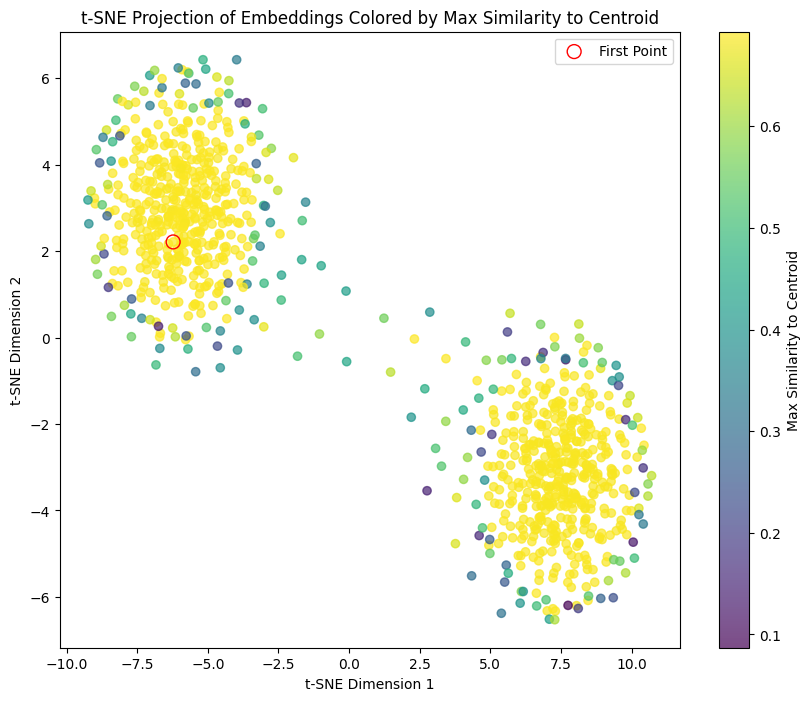

In [5]:
# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(combined_embeddings)

# Plotting the embeddings colored by max similarity to centroid
plt.figure(figsize=(10, 8))

# Scatter all points with max_similarity_to_centroids color
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=entropies, cmap="viridis", alpha=0.7)

# Highlight the first point with a different color (outline)
plt.scatter(embeddings_2d[0, 0], embeddings_2d[0, 1], edgecolor='red', facecolor='none', s=100, label="First Point")

# Add colorbar for max similarity to centroid values
plt.colorbar(scatter, label="Max Similarity to Centroid")

# Add labels and title
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Projection of Embeddings Colored by Max Similarity to Centroid")

# Show plot
plt.legend()
plt.show()